<a href="https://colab.research.google.com/github/RogerUltimate/-Keras-study---project/blob/main/%EB%94%B0%EB%A6%89%EC%9D%B4_Dense_GRU_AK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dense_GRU_AK 수정사항(이기성)

* Dense, GRU, auto keras 모델 추가
* 이상치(outlier)를 IQR 방법으로 제거
* value_counts 보기 추가
* Normalize

EDA_01 수정사항(이기성)

* 파일을 깃허브에서 불러오는 방법 추가
* 결측치 갯수를 확인하고 보간법으로 처리하는 방법 추가

In [75]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

파일을 github의 -Keras-study---project 폴더에서 불러오는 방법 추가

In [76]:
!curl -O https://raw.githubusercontent.com/RogerUltimate/-Keras-study---project/main/train.csv
!curl -O https://raw.githubusercontent.com/RogerUltimate/-Keras-study---project/main/test.csv
!curl -O https://raw.githubusercontent.com/RogerUltimate/-Keras-study---project/main/submission.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80667  100 80667    0     0   455k      0 --:--:-- --:--:-- --:--:--  455k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35719  100 35719    0     0   155k      0 --:--:-- --:--:-- --:--:--  155k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4631  100  4631    0     0  32159      0 --:--:-- --:--:-- --:--:-- 32159


In [77]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [78]:
"""
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Keras study/따릉이 예측/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Keras study/따릉이 예측/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Keras study/따릉이 예측/submission.csv')
"""

"\ntrain = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Keras study/따릉이 예측/train.csv')\ntest = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Keras study/따릉이 예측/test.csv')\nsubmission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Keras study/따릉이 예측/submission.csv')\n"

- id : 날짜와 시간별 id
- hour_bef_temperature : 1시간 전 기온
- hour_bef_precipitation : 1시간 전 비 정보, 비가 오지 않았으면 0 비가 오면 1
- hour_bef_windspeed : 1시간 전 풍속(평균)
- hour_bef_humidity : 1시간 전 습도
- hour_bef_visibility : 1시간 전 시정, 시계(특정 기상 상태에 따른 가시성을 의미)
- hour_bef_ozone : 1시간 전 오존
- hour_bef_pm10 : 1시간 전 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
- hour_bef_pm2.5 : 1시간 전 미세먼저(머리카락 굵기의 1/20 에서 1/30 크기의 미세먼지)
- count : 시간에 따른 따릉이 대여 수



In [79]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [80]:
test.head() #count columns 존재 하지 않음

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


In [81]:
submission.head() #id별 test data 예측값 넣기

,id,count
0,0,NaN
1,1,NaN
2,2,NaN
3,4,NaN
4,5,NaN


In [82]:
train.tail()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
1454,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0,21.0
1455,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0,20.0
1456,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0,22.0
1457,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0,216.0
1458,2179,17,21.1,0.0,3.1,47.0,1973.0,0.046,38.0,17.0,170.0


In [83]:
print(train.shape)
print(test.shape)
print(submission.shape)

(1459, 11)
(715, 10)
(715, 2)


In [84]:
train.info() #결측값 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


# 결측치 갯수/비율 확인하고 처리하기 추가

In [85]:
# 결측치 갯수 및 비율 확인
missing_count = train.isnull().sum()
missing_percentage = round(missing_count / len(train) * 100, 1)
missing_info = pd.concat([missing_count, missing_percentage], axis=1, keys=['missing count', 'missing %'])
missing_info.head(20)

,missing count,missing %
id,0,0.0
hour,0,0.0
hour_bef_temperature,2,0.1
hour_bef_precipitation,2,0.1
hour_bef_windspeed,9,0.6
hour_bef_humidity,2,0.1
hour_bef_visibility,2,0.1
hour_bef_ozone,76,5.2
hour_bef_pm10,90,6.2
hour_bef_pm2.5,117,8.0


In [86]:
# 따릉이 데이터의 경우 피쳐들은 기상정보들이며 데이터의 순서는 시간 순서입니다.
# 따라서 결측치들을 이전 행(직전시간)과 다음 행(직후시간)의 평균으로 보간하는 것은 상당히 합리적입니다.
# 이처럼 데이터에 따라서 결측치를 어떻게 대체할지 결정하는 것은 엔지니어의 결정입니다.
# 이를 Python pandas 의 interpolate() method 를 사용해 구현해보겠습니다.

train.interpolate(inplace=True)

In [87]:
# 결측치 처리 후 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1459 non-null   float64
 3   hour_bef_precipitation  1459 non-null   float64
 4   hour_bef_windspeed      1459 non-null   float64
 5   hour_bef_humidity       1459 non-null   float64
 6   hour_bef_visibility     1459 non-null   float64
 7   hour_bef_ozone          1459 non-null   float64
 8   hour_bef_pm10           1459 non-null   float64
 9   hour_bef_pm2.5          1459 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [88]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      715 non-null    int64  
 1   hour                    715 non-null    int64  
 2   hour_bef_temperature    714 non-null    float64
 3   hour_bef_precipitation  714 non-null    float64
 4   hour_bef_windspeed      714 non-null    float64
 5   hour_bef_humidity       714 non-null    float64
 6   hour_bef_visibility     714 non-null    float64
 7   hour_bef_ozone          680 non-null    float64
 8   hour_bef_pm10           678 non-null    float64
 9   hour_bef_pm2.5          679 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB


In [89]:
# 결측치 갯수 및 비율 확인
missing_count = test.isnull().sum()
missing_percentage = round(missing_count / len(test) * 100, 1)
missing_info = pd.concat([missing_count, missing_percentage], axis=1, keys=['missing count', 'missing %'])
missing_info.head(20)

,missing count,missing %
id,0,0.0
hour,0,0.0
hour_bef_temperature,1,0.1
hour_bef_precipitation,1,0.1
hour_bef_windspeed,1,0.1
hour_bef_humidity,1,0.1
hour_bef_visibility,1,0.1
hour_bef_ozone,35,4.9
hour_bef_pm10,37,5.2
hour_bef_pm2.5,36,5.0


In [90]:
test.interpolate(inplace=True)

In [91]:
# 결측치 처리 후 확인
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      715 non-null    int64  
 1   hour                    715 non-null    int64  
 2   hour_bef_temperature    715 non-null    float64
 3   hour_bef_precipitation  715 non-null    float64
 4   hour_bef_windspeed      715 non-null    float64
 5   hour_bef_humidity       715 non-null    float64
 6   hour_bef_visibility     715 non-null    float64
 7   hour_bef_ozone          715 non-null    float64
 8   hour_bef_pm10           715 non-null    float64
 9   hour_bef_pm2.5          715 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB


# 이상치(outlier) 제거

* 이상치 데이터는 모델의 성능을 크게 떨어트립니다. 
* 이상치를 탐지하는 대표적인 방법은 IQR (Inter Qunatile Range: 4분위 값들 사이의 거리, 즉 1/4분위와 3/4분위 사이의 길이) 로서, 
* 사분위 값의 편차를 이용합니다. 이를 boxplot 그래프로 볼 수 있습니다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


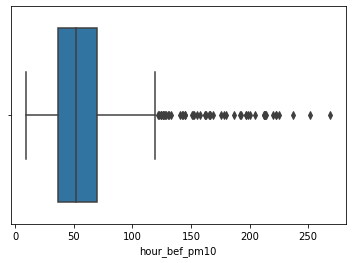

In [92]:
import seaborn as sns

sns.boxplot(train.hour_bef_pm10)

In [93]:
# IQR 방법을 이용한 이상치 제거
import numpy as np
quantile_25 = np.quantile(train['hour_bef_pm10'], 0.25)
quantile_75 = np.quantile(train['hour_bef_pm10'],0.75)
IQR = quantile_75 - quantile_25
minimum = quantile_25 - 1.5 * IQR
maximum = quantile_75 + 1.5 * IQR
train2 = train[(minimum <= train['hour_bef_pm10']) & (train['hour_bef_pm10'] <= maximum)]

train2.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000
mean,1106.906050,11.502491,16.681993,0.032028,2.466192,52.699288,1421.148043,0.039269,53.176868,30.349822,109.590036
std,631.333977,6.971004,5.294138,0.176138,1.365191,20.409818,584.212066,0.019306,21.279973,14.370282,83.433128
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,559.000000,5.000000,12.700000,0.000000,1.400000,36.000000,888.000000,0.026000,36.000000,20.000000,37.000000
50%,1120.000000,11.000000,16.500000,0.000000,2.300000,52.000000,1628.000000,0.039000,51.000000,27.000000,97.000000
75%,1650.000000,18.000000,20.100000,0.000000,3.400000,69.000000,1996.000000,0.052000,67.000000,37.000000,152.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,119.000000,90.000000,431.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


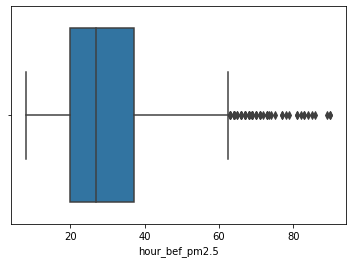

In [94]:
sns.boxplot(train2['hour_bef_pm2.5'])

In [95]:
# IQR 방법을 이용한 이상치 제거 (위와 코드 다름: train2 사용, 2.0배 사용)
#import numpy as np
quantile_25 = np.quantile(train2['hour_bef_pm2.5'], 0.25)
quantile_75 = np.quantile(train2['hour_bef_pm2.5'],0.75)
IQR = quantile_75 - quantile_25
minimum = quantile_25 - 2.0 * IQR
maximum = quantile_75 + 2.0 * IQR
train2 = train2[(minimum <= train2['hour_bef_pm2.5']) & (train2['hour_bef_pm2.5'] <= maximum)]

train2.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000
mean,1106.371656,11.519161,16.730369,0.032538,2.475922,52.803688,1432.655098,0.039350,52.517715,29.561099,110.310195
std,630.742862,6.976249,5.292013,0.177488,1.367501,20.446675,581.105735,0.019283,20.742225,13.019781,83.760650
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,558.500000,5.000000,12.800000,0.000000,1.400000,37.000000,911.500000,0.026000,36.000000,20.000000,37.000000
50%,1120.000000,11.000000,16.500000,0.000000,2.300000,52.000000,1636.000000,0.039000,50.000000,26.000000,98.000000
75%,1648.500000,18.000000,20.100000,0.000000,3.400000,69.500000,1997.500000,0.052000,66.000000,36.000000,153.500000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,119.000000,71.000000,431.000000


In [96]:
# train2를 train으로 저장
train = train2

In [97]:
# IQR 방법을 이용한 이상치 제거 함수화: 실패. 
# 잘 되는 듯 보이지만 데이터에 변화가 없음
import numpy as np

def get_iqr(df, col_name):
    quantile_25 = np.quantile(col_name, 0.25)
    quantile_75 = np.quantile(col_name,0.75)
    IQR = quantile_75 - quantile_25
    minimum = quantile_25 - 1.5 * IQR
    maximum = quantile_75 + 1.5 * IQR
    df = df[(minimum <= col_name) & (col_name <= maximum)]
    return df

In [98]:
get_iqr(train2, train2.hour_bef_pm10)

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...,...
1454,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0,21.0
1455,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0,20.0
1456,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0,22.0
1457,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0,216.0


In [99]:
train2.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000
mean,1106.371656,11.519161,16.730369,0.032538,2.475922,52.803688,1432.655098,0.039350,52.517715,29.561099,110.310195
std,630.742862,6.976249,5.292013,0.177488,1.367501,20.446675,581.105735,0.019283,20.742225,13.019781,83.760650
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,558.500000,5.000000,12.800000,0.000000,1.400000,37.000000,911.500000,0.026000,36.000000,20.000000,37.000000
50%,1120.000000,11.000000,16.500000,0.000000,2.300000,52.000000,1636.000000,0.039000,50.000000,26.000000,98.000000
75%,1648.500000,18.000000,20.100000,0.000000,3.400000,69.500000,1997.500000,0.052000,66.000000,36.000000,153.500000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,119.000000,71.000000,431.000000


In [100]:
train.describe() #data 통계 확인. hour_bef_pm10, hour_bef_pm2.5의 max값을 보면 IQR로 조정할 때 사용한 maximum 값보다 작기 때문에 이상치 제거 불필요함

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000
mean,1106.371656,11.519161,16.730369,0.032538,2.475922,52.803688,1432.655098,0.039350,52.517715,29.561099,110.310195
std,630.742862,6.976249,5.292013,0.177488,1.367501,20.446675,581.105735,0.019283,20.742225,13.019781,83.760650
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,558.500000,5.000000,12.800000,0.000000,1.400000,37.000000,911.500000,0.026000,36.000000,20.000000,37.000000
50%,1120.000000,11.000000,16.500000,0.000000,2.300000,52.000000,1636.000000,0.039000,50.000000,26.000000,98.000000
75%,1648.500000,18.000000,20.100000,0.000000,3.400000,69.500000,1997.500000,0.052000,66.000000,36.000000,153.500000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,119.000000,71.000000,431.000000


In [101]:
test.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
count,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000
mean,1056.854545,11.472727,23.269371,0.051748,2.389860,56.658042,1359.088112,0.041359,36.887413,24.893007
std,625.574471,6.928427,4.040072,0.221673,1.171002,19.649935,613.837771,0.020369,12.566943,9.973823
min,0.000000,0.000000,14.600000,0.000000,0.000000,16.000000,126.000000,0.003000,9.000000,7.000000
25%,507.000000,5.500000,20.300000,0.000000,1.500000,42.000000,808.500000,0.027750,28.000000,17.000000
50%,1046.000000,11.000000,22.900000,0.000000,2.300000,55.000000,1481.000000,0.039000,35.000000,24.000000
75%,1616.500000,17.000000,26.400000,0.000000,3.300000,73.500000,2000.000000,0.052750,45.000000,31.000000
max,2177.000000,23.000000,33.800000,1.000000,5.900000,100.000000,2000.000000,0.138000,94.000000,69.000000


# 그래프

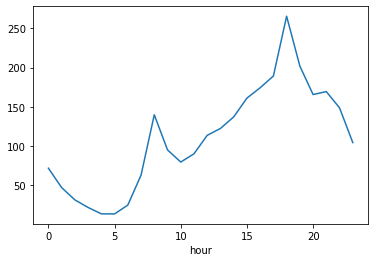

In [ ]:
train.groupby('hour').mean()['count'].plot() #시간대별로 count 평균 그래프

Text(18, 120, 'leave work')

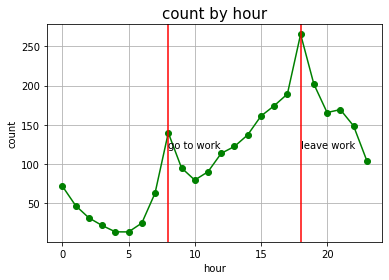

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train.groupby('hour').mean()['count'], 'go-' )
plt.title('count by hour', fontsize=15)
plt.xlabel('hour')
plt.ylabel('count')
plt.grid()
plt.savefig('picture.png')
plt.axvline(8, color = 'r')
plt.axvline(18, color = 'r')
plt.text(8, 120, 'go to work', fontsize=10)
plt.text(18, 120, 'leave work', fontsize=10)


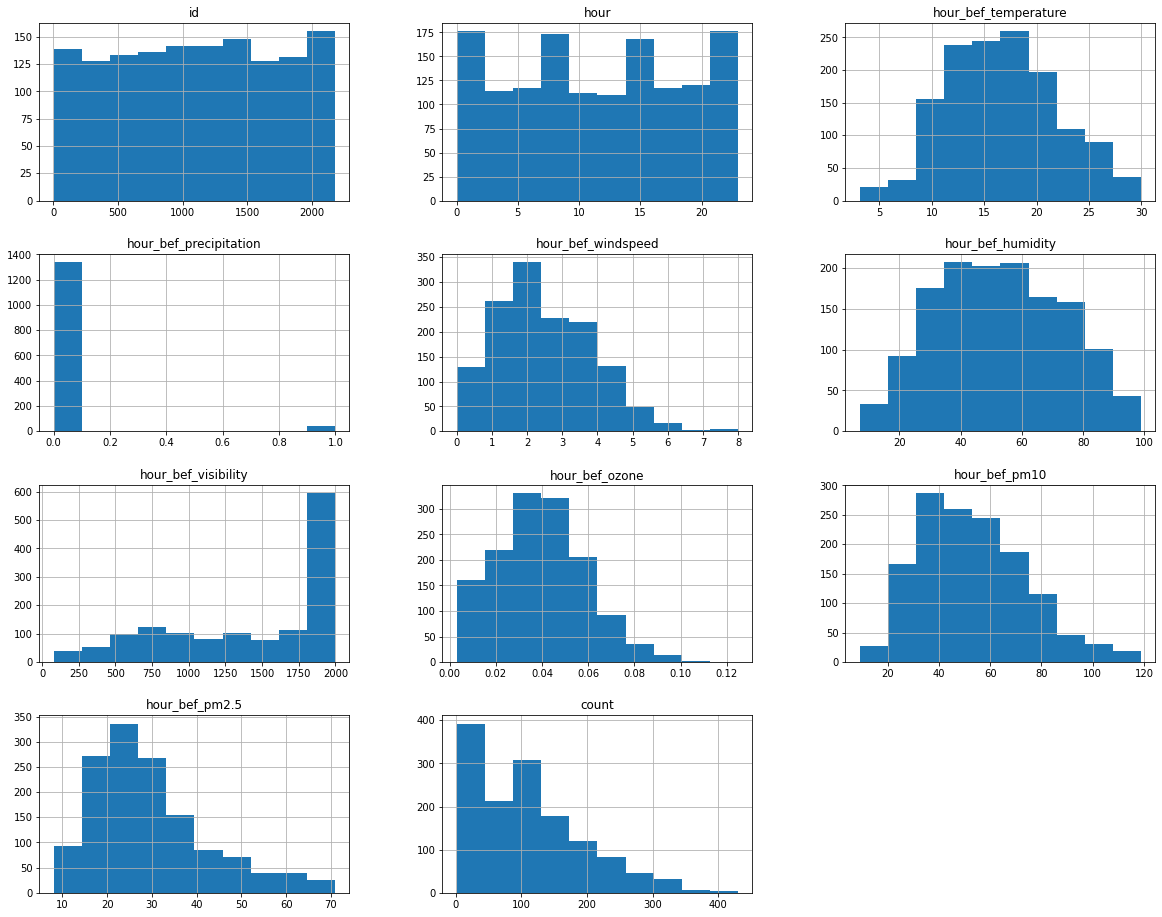

In [ ]:
# 각 특성별 value count 보기
train.hist(figsize=(20, 16))
plt.show()

In [ ]:
# 강수 예측에 대해 value count 자세히 보기
train.hour_bef_precipitation.value_counts()

0.0    1338
1.0      45
Name: hour_bef_precipitation, dtype: int64

# 상관계수
상관계수가 높은 변수를 확인하여 채택하는 것이 가장 간단한 방법

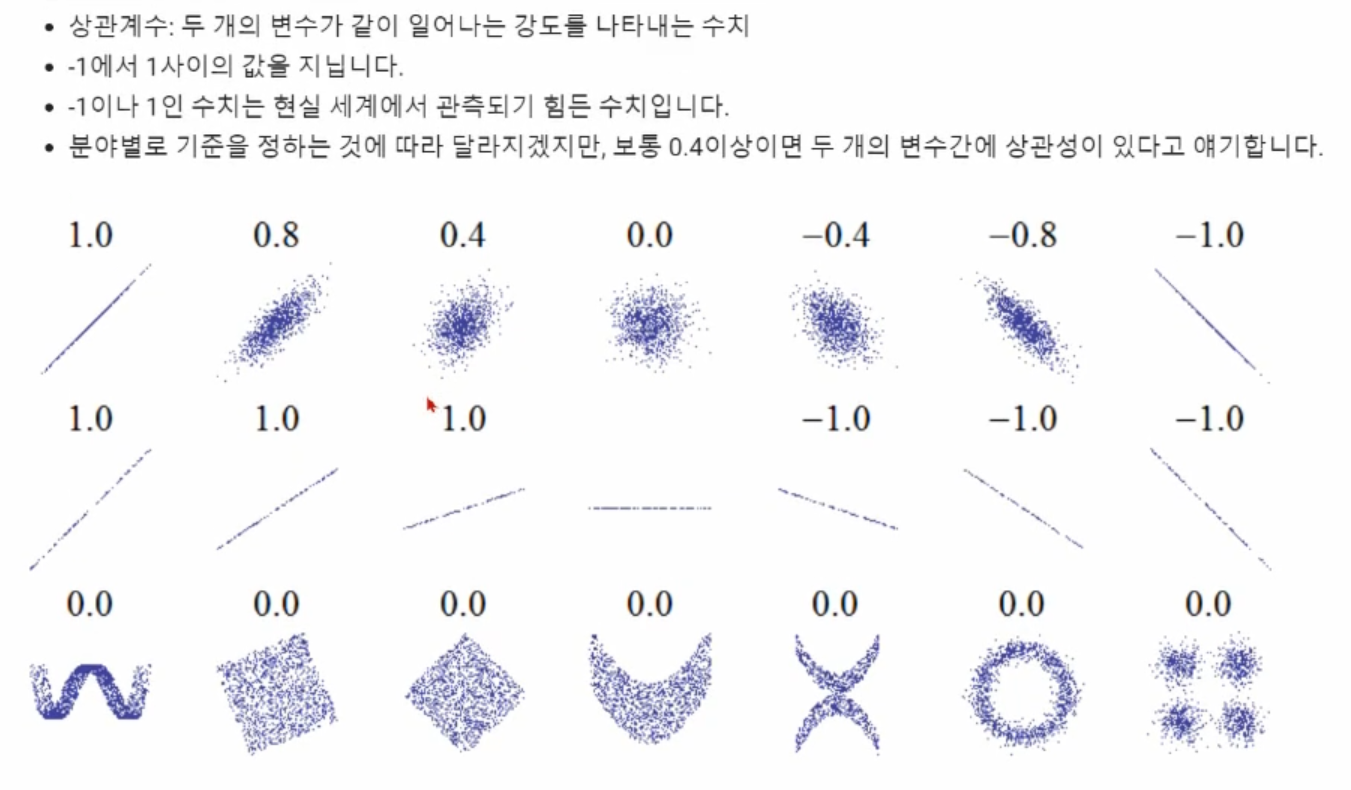

- 상관계수가 높은 변수를 확인하여 채택하는 것이 가장 간단한 방법

In [ ]:
train.corr()  #변수 간에 상관관계

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
id,1.000000,-0.013803,0.002498,-0.055055,-0.006369,-0.020043,0.006236,0.052687,-0.017826,0.006339,-0.004576
hour,-0.013803,1.000000,0.406339,0.019657,0.468343,-0.336750,0.181949,0.348161,-0.049302,-0.081897,0.628333
hour_bef_temperature,0.002498,0.406339,1.000000,-0.097118,0.375031,-0.510791,0.202264,0.514283,-0.022898,-0.060763,0.625156
hour_bef_precipitation,-0.055055,0.019657,-0.097118,1.000000,0.017242,0.273727,-0.227114,-0.063058,-0.027673,0.022154,-0.166604
hour_bef_windspeed,-0.006369,0.468343,0.375031,0.017242,1.000000,-0.436775,0.261508,0.496781,-0.034655,-0.180522,0.475276
hour_bef_humidity,-0.020043,-0.336750,-0.510791,0.273727,-0.436775,1.000000,-0.638395,-0.403744,0.008573,0.191478,-0.498513
hour_bef_visibility,0.006236,0.181949,0.202264,-0.227114,0.261508,-0.638395,1.000000,0.092734,-0.405814,-0.594563,0.294426
hour_bef_ozone,0.052687,0.348161,0.514283,-0.063058,0.496781,-0.403744,0.092734,1.000000,0.142952,0.027270,0.460104
hour_bef_pm10,-0.017826,-0.049302,-0.022898,-0.027673,-0.034655,0.008573,-0.405814,0.142952,1.000000,0.648896,-0.087815
hour_bef_pm2.5,0.006339,-0.081897,-0.060763,0.022154,-0.180522,0.191478,-0.594563,0.027270,0.648896,1.000000,-0.128498


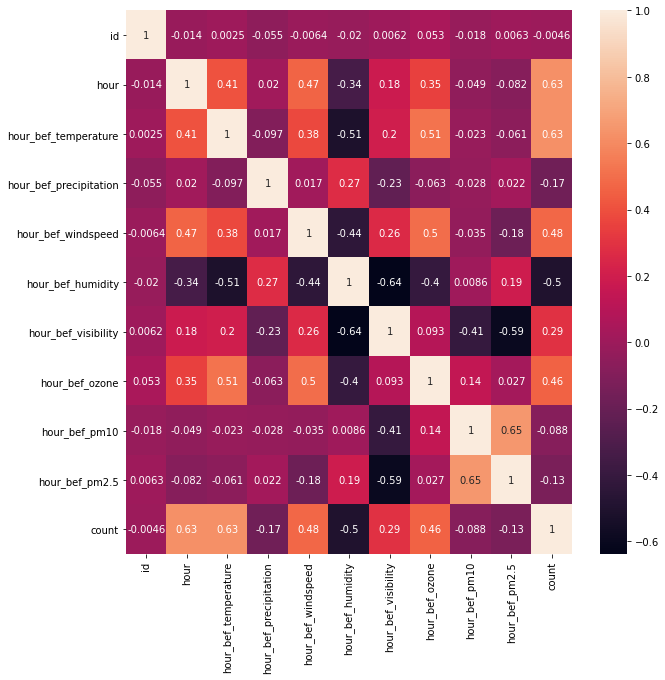

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,10))   #변수들 간의 상관관계 확인 
sns.heatmap(train.corr(), annot = True)

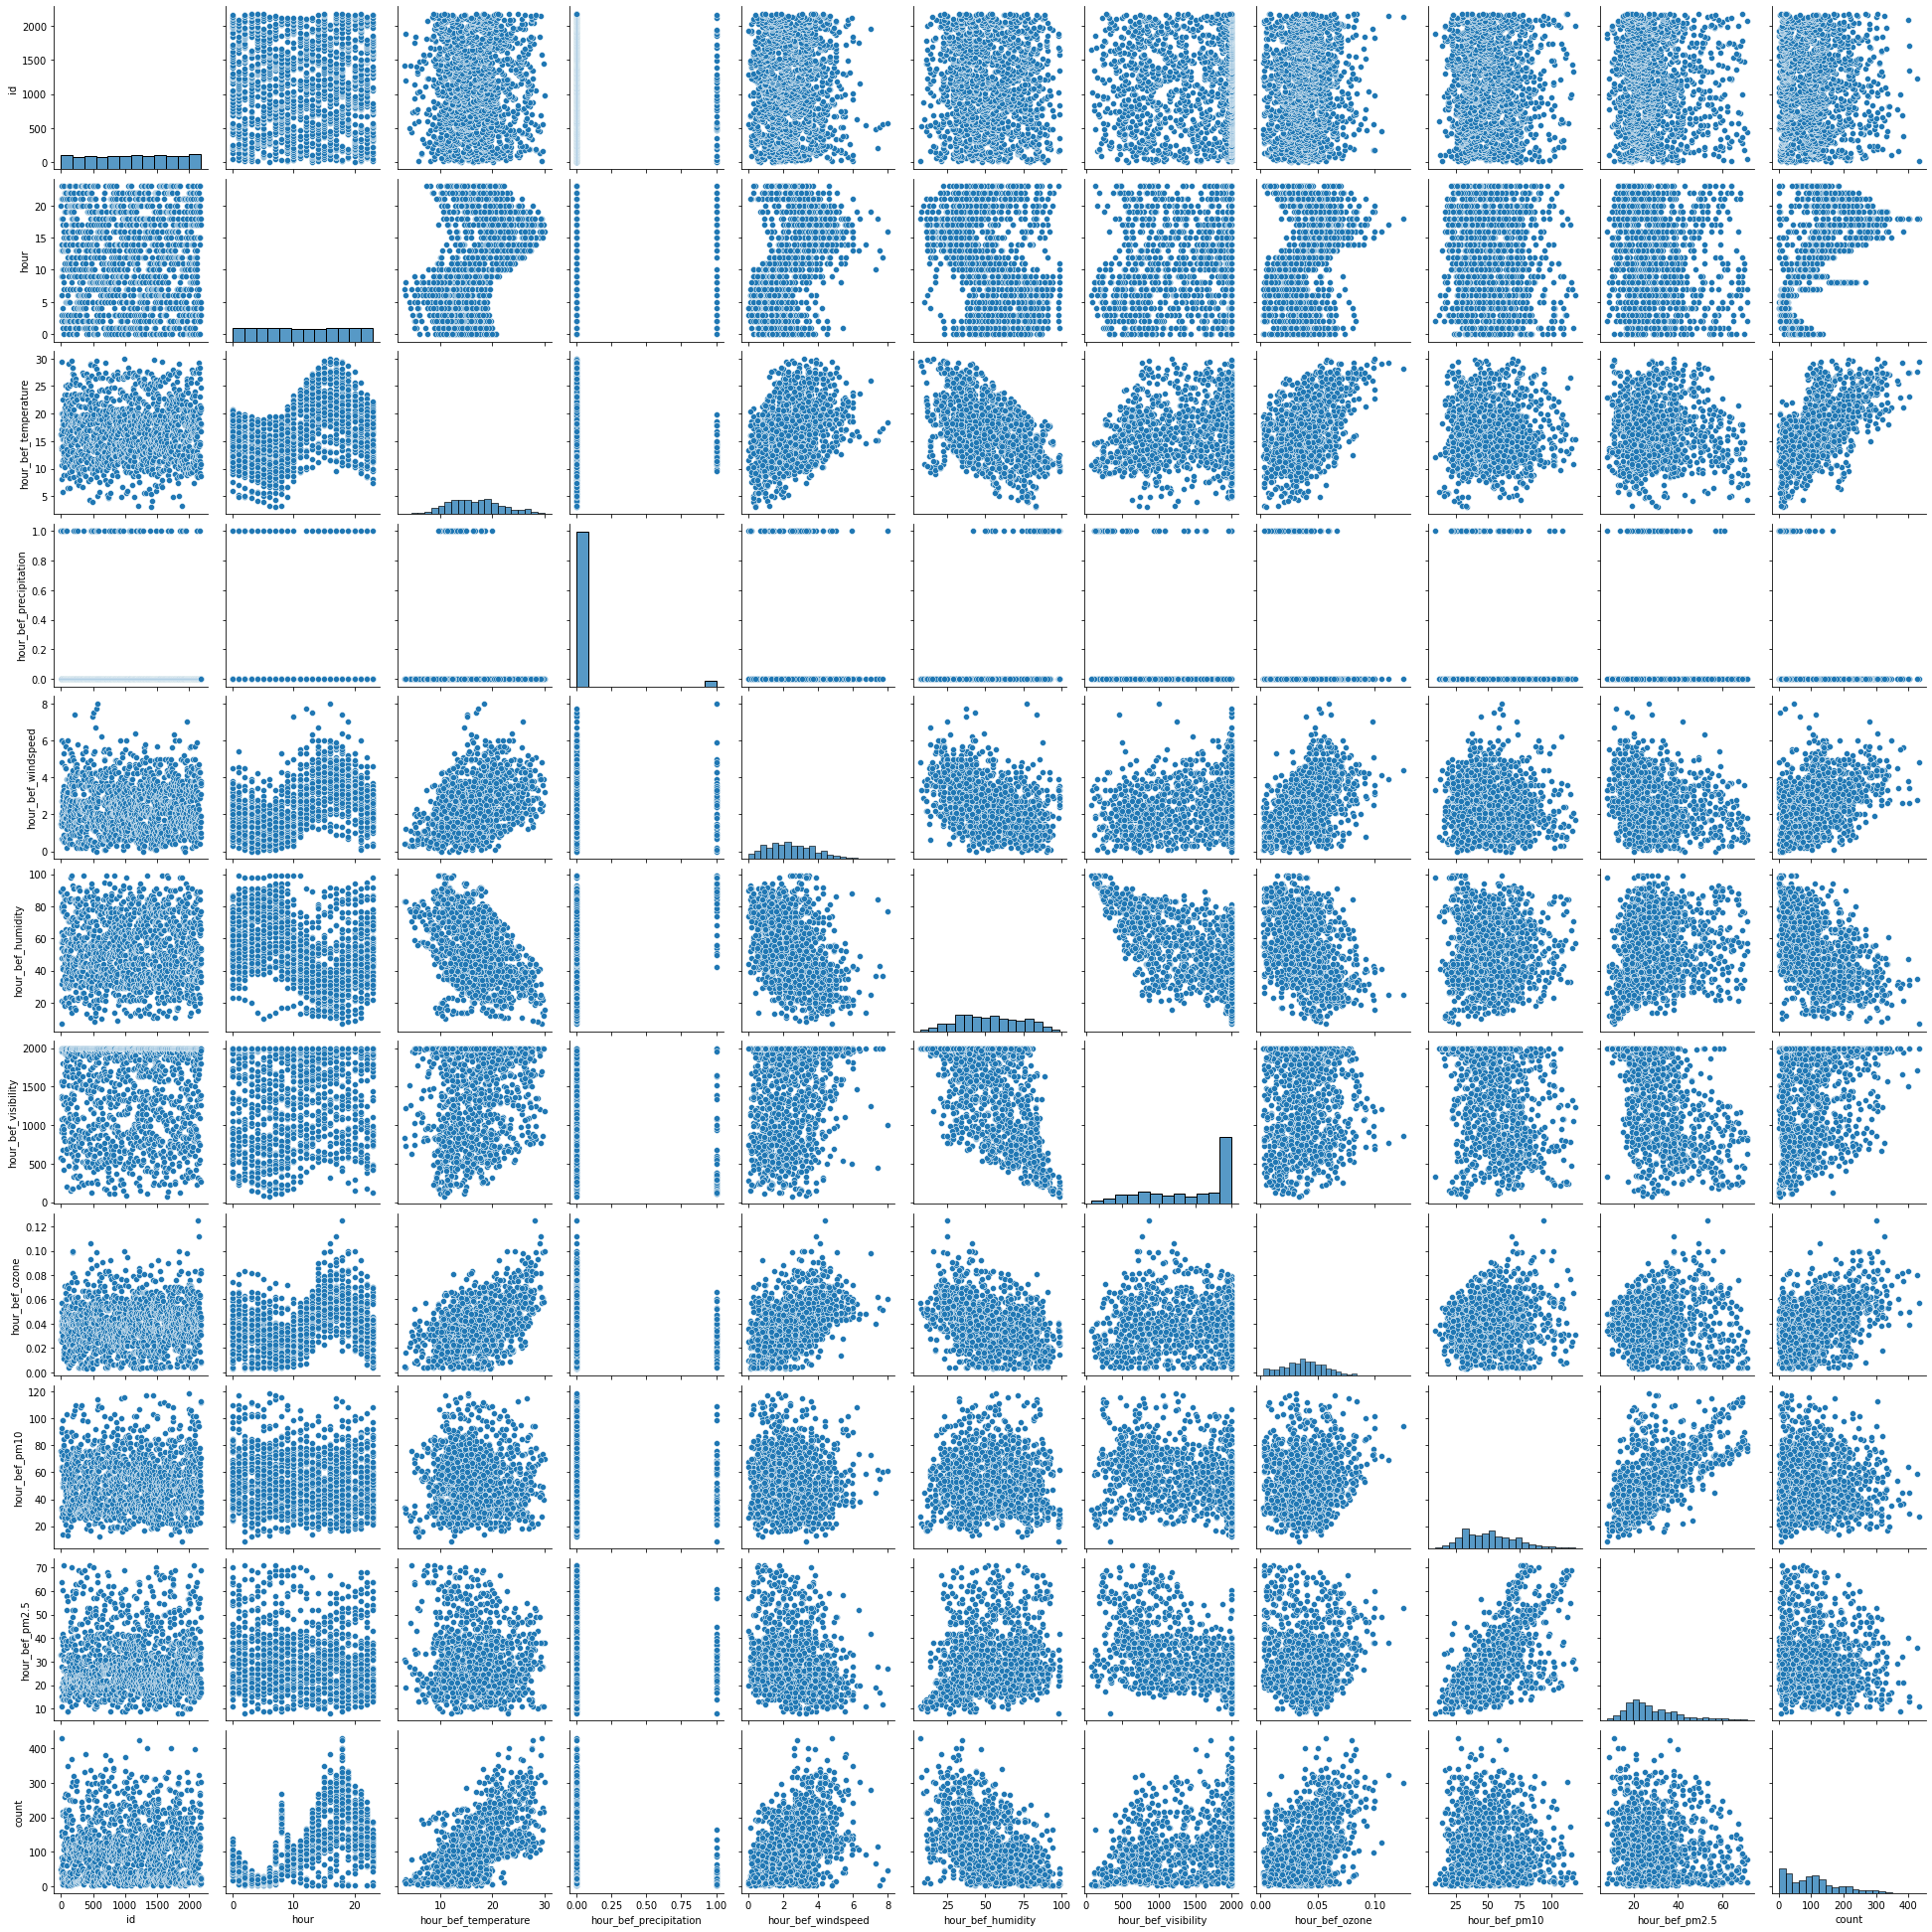

In [ ]:
sns.pairplot(train) 

# Normalize

In [103]:
cols = ['hour', 'hour_bef_temperature', 'hour_bef_precipitation',
              'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
              'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5']

In [110]:
train2 = train[cols]

In [108]:
def normalize(df):
    df_mean = df.mean()
    df_std = df.std()
    df = (df - df_mean) / df_std
    return df 

In [141]:
train2 = normalize(train2)

In [112]:
test2 = test[cols]

In [142]:
test2 = normalize(test2)

In [143]:
X_train = train2
X_test = test2
y_train = train['count']

# 기존 normalize 방법(폐기)

In [ ]:
nor_train = pd.DataFrame(train['id'])

In [ ]:
def normalize(df, col_name, nor_df):
    df_mean = df[col_name].mean()
    df_std = df[col_name].std()
    nor_df[col_name] = (df[col_name] - df_mean) / df_std
    return nor_df 

In [ ]:
for cols in train_cols:
    normalize(train, cols, nor_train)

In [ ]:
nor_train.head(3)

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,3,1.215673,-0.081324,5.450856,-0.713653,1.770279,-1.474181,-0.640467,1.132101,0.264129
1,6,0.212269,0.636739,-0.183325,-0.786779,-0.234937,-0.889090,0.137408,0.987468,0.801772
2,7,-0.791136,-0.534838,-0.183325,-1.298662,1.281202,-0.087170,-0.329317,-0.989176,-0.811158


In [ ]:
nor_train = nor_train.drop(['id'], axis='columns')

In [ ]:
nor_test = pd.DataFrame(test['id'])

In [ ]:
for cols in train_cols:
    normalize(test, cols, nor_test)

In [ ]:
nor_test.head(3)

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,-0.645562,-0.635971,-0.233444,-0.930708,0.271856,-0.659927,-0.017647,0.565976,0.211252
1,1,0.797767,1.665968,-0.233444,2.570568,-1.203976,0.376177,0.964248,0.963845,1.113614
2,2,0.220436,-1.056756,4.277697,-0.247532,1.951251,-1.899668,-1.048636,-0.070615,0.311515


In [ ]:
nor_test = nor_test.drop(['id'], axis='columns')

In [ ]:
X_train = nor_train
X_test = nor_test
y_train = train['count']

In [ ]:
"""
# StandardScaler
# 0값과 1값이 있을 경우 각각 0.1과 0.9로 바꾸는 것이 좋음. 여기서는 hour_bef_precipitation이 해당
# StandardScaler를 쓸 경우 GRU의 loss, mae가 'nan'이 나옴

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
scale_cols = ['hour_bef_temperature','hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
              'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5']       # id, hour, hour_bef_precipitation, count 제외
scaled_df = scaler.fit_transform(train[scale_cols])   
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
scaled_df['hour_bef_precipitation'] = train['hour_bef_precipitation'].map({0:0.1, 1:0.9}) 
scaled_df['hour'] = train['hour']
X_train = scaled_df
y_train = train['count']

# StandardScaler is useful for the features that follow a Normal distribution. 
# MinMaxScaler may be used when the upper and lower boundaries are well known from domain knowledge 
# (e.g. pixel intensities that go from 0 to 255 in the RGB color range).
# 0 --> 0.1, 1 --> 0.9 (https://datascience.stackexchange.com/questions/43972/when-should-i-use-standardscaler-and-when-minmaxscaler)
"""

In [ ]:
"""scaled_test = scaler.fit_transform(test[scale_cols])   
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)
scaled_test['hour_bef_precipitation'] = test['hour_bef_precipitation'].map({0:0.1, 1:0.9}) 
scaled_test['hour'] = test['hour']
X_test = scaled_test"""

In [ ]:
"""
X_train = train.drop(['id', 'count'], axis='columns')  
y_train = train['count']                            # train[:, -1] 안 됨
print(X_train.shape, y_train.shape)

test = test.drop(['id'], axis='columns')
"""

(1383, 9) (1383,)


# GRU

In [115]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [145]:
X_train.shape

(1383, 9)

In [146]:
X_train2 = np.expand_dims(X_train,  -1)

In [147]:
X_train2.shape

(1383, 9, 1)

In [150]:
from keras import backend as K
K.clear_session()

In [151]:
# GRU: val_loss 최저값 1705 --> Normalize 한 뒤 1610 (돌릴 때마다 차이가 있음) [epochs 120]
# Dense: val_loss 최저값 1915 --> Normalize한 뒤에는 1400 정도로 엄청난 감소   [epochs 100]
# Normalize 하기 전에는 GRU가 Dense보다 좋았으나, Normalize 후에는 Dense가 훨씬 좋아짐
# train과 test를 따로 normalize하면서 서로 다른 평균과 표준편차를 사용하고, 이로 인하여
# 데이터의 왜곡이 발생?

from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(GRU(16, input_shape=(9,1)))
model.add(Dense(1))   #,activation='linear'))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.01), metrics=['mae'])
model.summary()

#early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train2, y_train, validation_split=0.2, epochs=120, batch_size=32)  #, callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16)                912       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
35/35 [==============================] - 3s 18ms/step - loss: 18273.4316 - mae: 105.4140 - val_loss: 15930.0771 - val_mae: 97.9380
Epoch 2/120
35/35 [==============================] - 0s 7ms/step - loss: 16602.7949 - mae: 98.0707 - val_loss: 14706.9092 - val_mae: 92.7112
Epoch 3/120
35/35 [==============================] - 0s 7ms/step - loss: 15427.0273 - mae: 93.1865 - val_loss: 13650.4717 - val_mae: 88.4425
Epoch 4/120
35/35 [==============================] - 0s 7ms/step - loss: 14405.1084 - mae: 89.1

# Dense

In [152]:
# val_loss 최저값 1915 --> Normalize한 뒤에는 1400 내외로 엄청난 감소
inputs = keras.Input(shape=(X_train.shape[-1],))

x = Dense(256, activation="relu")(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# 선형회귀는 출력층에 활성화 함수 지정할 필요 없음
outputs = Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.Adam(0.01), loss='mse')   #, metrics=[tensorflow.keras.metrics.CategoricalAccuracy])
callbacks = [keras.callbacks.ModelCheckpoint("dda_1_{epoch}.h5")]
model.fit(X_train, y_train, epochs=100, verbose=1, batch_size=32,
    callbacks=callbacks,    validation_split=0.2)

Epoch 1/100
35/35 [==============================] - 1s 10ms/step - loss: 13783.3115 - val_loss: 16933.3691
Epoch 2/100
35/35 [==============================] - 0s 5ms/step - loss: 6073.0215 - val_loss: 2460.9143
Epoch 3/100
35/35 [==============================] - 0s 6ms/step - loss: 2758.3052 - val_loss: 2055.1719
Epoch 4/100
35/35 [==============================] - 0s 5ms/step - loss: 2550.2419 - val_loss: 1923.2965
Epoch 5/100
35/35 [==============================] - 0s 5ms/step - loss: 2549.1841 - val_loss: 1817.6566
Epoch 6/100
35/35 [==============================] - 0s 6ms/step - loss: 2584.3774 - val_loss: 1789.8989
Epoch 7/100
35/35 [==============================] - 0s 5ms/step - loss: 2425.7693 - val_loss: 1890.7007
Epoch 8/100
35/35 [==============================] - 0s 5ms/step - loss: 2494.5806 - val_loss: 1573.2219
Epoch 9/100
35/35 [==============================] - 0s 5ms/step - loss: 2499.5928 - val_loss: 1764.2614
Epoch 10/100
35/35 [==============================] 

In [ ]:
# model.load_weights('dda_12.h5')

In [ ]:
pred = model.predict(X_test).flatten()   # [[ ],[ ],[ ]....[ ]] --> [ ]

In [ ]:
print(pred)

In [ ]:
submission['count'] = pred
submission.to_csv('dda_sub_2.csv', index = False)

# auto keras

In [ ]:
# autokeras 설치를 먼저 해야 함
!pip install autokeras

In [153]:
# loss를 mse로 잘 잡아서 학습을 하고 있음
# 성과는 위의 Dense만 못함

import autokeras as ak

# StructuredDataRegressor로 설정하여, 5개의 모델을 시도
# TimeSeriesForecaster로 시도?
reg = ak.StructuredDataRegressor(max_trials=5, overwrite=True)
# Feed the structured data regressor with training data.
reg.fit(X_train, y_train, epochs=100)
# Predict with the best model.
predicted_y = reg.predict(X_test)
# Evaluate the best model with testing data.
#print(reg.evaluate(x_test, y_test))

Trial 5 Complete [00h 00m 19s]
val_loss: 2149.880126953125

Best val_loss So Far: 2096.577392578125
Total elapsed time: 00h 01m 54s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 15163.7344 - mean_squared_error: 15163.7344
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 8207.9697 - mean_squared_error: 8207.9697
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 5554.2290 - mean_squared_error: 5554.2290
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 3809.3157 - mean_squared_error: 3809.3157
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 3136.6960 - mean_squared_error: 3136.6960
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 2914.2998 - mean_squared_error: 2914.2998
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 2821.0598 - mean_squared_error: 2821.0598
Epoch 8/100
44/44 [====